created by **Farah Rabie** (fr2007@hw.ac.uk)

#### Notebook 1$\,\,\,\,\,$ K-Means Clustering for Well Data

This notebook focuses on clustering well log data for lithology identification. The **two tasks** covered in this notebook include:

- Visualising correlations between well properties across different lithologies.
- Clustering well log data using the K-Means algorithm.

The data in this notebook is sourced from the Equinor Volve Field dataset.

#### Import Libraries

First things first, let us import the necessary Python libraries. 

<span style="color:red"> Import the following:</span>

- <span style="color:red">NumPy (use alias *np*)
- <span style="color:red">Pandas (use alias *pd*)
- <span style="color:red">PyPlot sub-module from Matplotlib (use alias *plt*)
- <span style="color:red">Colors sub-module from Matplotlib (use alias *colors*)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

We will also be importing two additional Python libraries:

**Seaborn**

This is a Python data visualisation library based on Matplotlib. We are particularly interested in using *pairplot*, a function in seaborn. This function creates a grid of scatter plots for each pair of numerical variables in a dataset, along with histograms or kernel density estimates (KDE) for the distribution of individual variables. It is particularly useful for exploring relationships in multivariate data.

**KMeans**

This is a clustering algorithm from the *scikit-learn* library in Python. It partitions the dataset into a specified number of clusters (k) by assigning each data point to the nearest cluster center (centroid). The algorithm iteratively updates the centroids based on the mean of the points in each cluster until convergence is achieved. KMeans is widely used in unsupervised machine learning for grouping similar data points, making it suitable for applications like customer segmentation, image compression, and, as in this case, geological data analysis for identifying lithological groups based on well log data.

In [2]:
import seaborn as sns
from sklearn.cluster import KMeans

#### Task 1$\,\,\,\,\,$ Visualise Patterns Between Properties & Across Lithologies

Now, let us <span style="color:purple">load the well data into the **well_data** DataFrame</span>. 

The well log and lithology data from 7 wells in the Volve field is stored in the *combined_well_data_with_lithology.csv* file, in the Data folder. <span style="color:red"> Can you load the data in the **well_data** DataFrame, and inspect its content? </span>

In [3]:
well_data = pd.read_csv('../../Data/combined_well_data_with_lithology.csv')
well_data.head()

,Well Name,Depth,GR,NPHI,RHOB,RT,DT,Lithology_values,Lithology
0,15_9-F-12,239.8776,NaN,NaN,NaN,0.1015,NaN,NaN,NaN
1,15_9-F-12,240.0300,NaN,NaN,NaN,0.1000,NaN,NaN,NaN
2,15_9-F-12,240.1824,NaN,NaN,NaN,0.1000,NaN,NaN,NaN
3,15_9-F-12,240.3348,NaN,NaN,NaN,0.1000,NaN,NaN,NaN
4,15_9-F-12,240.4872,20.9848,NaN,NaN,0.1000,NaN,NaN,NaN


It looks like we have missing values (i.e. NaN entries). Missing data can introduce bias in the clustering process. For example, if certain clusters contain more missing values, it could skew the results, leading to incorrect interpretations. 

To improve the clustering quality, let us <span style="color:purple">remove all missing values</span>. <span style="color:red"> How would you go about it? </span>

**Hint**: use the *.dropna()* method

In [4]:
well_data['Well Name']

0         15_9-F-12
1         15_9-F-12
2         15_9-F-12
3         15_9-F-12
4         15_9-F-12
            ...    
200140    15_9-F-14
200141    15_9-F-14
200142    15_9-F-14
200143    15_9-F-14
200144    15_9-F-14
Name: Well Name, Length: 200145, dtype: object

In [5]:
well_data.dropna(inplace=True)

When exploring the relationship between pairs of properties across different lithology types, a *pairplot* is a good choice. Say, for example, that we are interested in understanding how *Gamma Ray* ($GR$) varies with $Depth$ across different *lithologies*. 

First, let us <span style="color:purple">create a separate DataFrame</span> called **subset_depth_gr**, containing only the Depth, GR, and Lithology columns from the **well_data** DataFrame.

In [6]:
subset_depth_gr = well_data[['Depth', 'GR', 'Lithology']]

Next, we will <span style="color:purple">use the *pairplot* function from the *seaborn* Python library to visualise the relationship between $GR$ and $Depth$ across different lithologies</span>. In a pairplot, we have the following sub-plots:

**Scatter Plots**
<br>These are the off-diagonal plots showing the relationship between two variables, in this case, $GR$ and $Depth$. Each point represents an observation, and the different colors indicate different lithology types.

**KDE Plots** (Kernel Density Estimation)
<br>These are the diagonal plots that show the distribution of individual variables (either $GR$ or $Depth$). KDE plots give us an understanding of the spread and density of each variable's values within the dataset.

<Figure size 400x400 with 0 Axes>

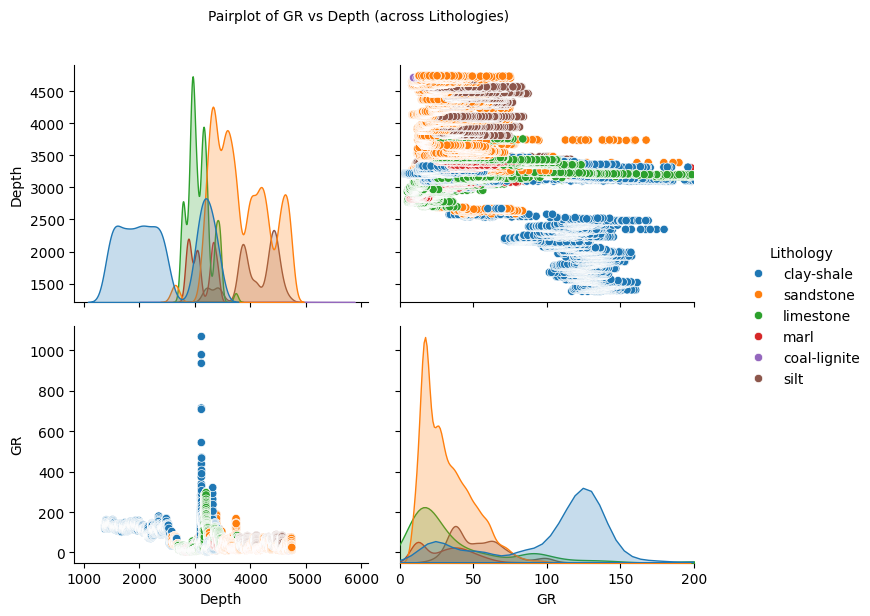

In [7]:
plt.figure(figsize=(4, 4))

# create pairplot
g = sns.pairplot(
    subset_depth_gr, 
    hue='Lithology', 
    height=3, 
    diag_kind='kde', 
    palette='tab10', 
    plot_kws=dict(marker="o", alpha=1.0)
)

plt.suptitle('Pairplot of GR vs Depth (across Lithologies)', fontsize=10, y=1.02) # add main title
g._legend.set_bbox_to_anchor((1.20, 0.5))  # position legend to right
plt.setp(g._legend.get_title(), fontsize=10)  # set title for legend
plt.xlim((0, 200)) # set limits for GR
plt.tight_layout() # adjust layout
plt.subplots_adjust(hspace=0.1) # adjust hspace value to increase/decrease space between rows of plots
        
plt.show()

<br><span style="color:red"> Can you create the pairplot for $NPHI$ vs $Depth$ (across lithologies)? </span>

#### Task 2$\,\,\,\,\,$ K-Means Algorithm for Well Data Clustering

We can now move on to the data clustering. The function *optimise_k_means* aims to determine the optimal number of clusters (k) for K-Means by analysing inertia (i.e., the sum of squared distances from each point to its assigned cluster center). Here is a breakdown of the function:

- It initialises two lists: means for tracking the number of clusters and inertias for their corresponding inertia values.
- For each number of clusters from 1 to *max_k*, it fits a K-Means model, appends the *k* value and its inertia to the respective lists.
- Finally, it plots the number of clusters against inertia, allowing you to visually assess where inertia starts to level off (the "elbow" method) to choose an optimal *k*.

The *well_splitter* function groups the well data by well name, creating individual DataFrames for each well.

In [8]:
# splitting data by well names
def well_splitter(dataframe, groupby_column):
    grouped = dataframe.groupby(groupby_column)
    
    # create empty lists
    wells_as_dfs = []
    wells_wellnames = []

    # split up the data by well
    for well, data in grouped:
        wells_as_dfs.append(data)
        wells_wellnames.append(well)

    print('index  wellname')
    for i, name in enumerate(wells_wellnames):
        print(f'{i}      {name}')
    
    return wells_as_dfs, wells_wellnames

dfs_wells, wellnames = well_splitter(well_data, 'Well Name')

index  wellname
0      15_9-F-1 B
1      15_9-F-11 B
2      15_9-F-12
3      15_9-F-15 C
4      15_9-F-4
5      15_9-F-5


In [9]:
training_wells = pd.concat([dfs_wells[0], dfs_wells[1], dfs_wells[2], dfs_wells[3]])
training_well_names = [wellnames[0], wellnames[1], wellnames[2], wellnames[3]]

testing_wells = pd.concat([dfs_wells[4], dfs_wells[5]])
testing_well_names = [wellnames[4], wellnames[5]]

Let us <span style="color:purple">define a function and run it</span>, using $GR$, $RHOB$, $NPHI$ and $RHOB$ as our inputs, and *max_k* = 10.

k: 1
inertia:  68106844.76702265
k: 2
inertia:  17745381.655738264
k: 3
inertia:  11420486.654836696
k: 4
inertia:  6549952.965276362
k: 5
inertia:  4512843.658167515
k: 6
inertia:  3019880.4550190405
k: 7
inertia:  2225787.609921069
k: 8
inertia:  1774036.0372725474
k: 9
inertia:  1428570.7727843826


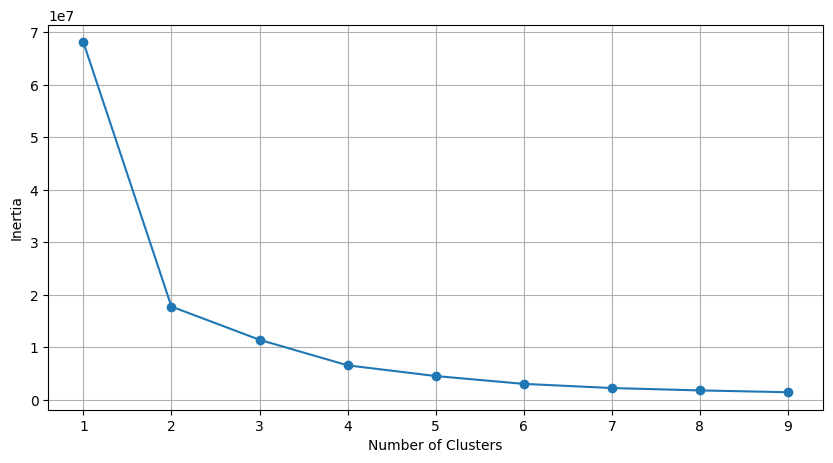

In [10]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters = k, n_init=10)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        print('k:', k)
        print('inertia: ', kmeans.inertia_)
        
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

# prepare data for clustering
kmeans_data = training_wells[['GR', 'RHOB', 'NPHI']]  # replace with the relevant features
# set the maximum number of clusters to explore
max_k = 10
# call the function to optimize K-Means
optimise_k_means(kmeans_data, max_k)

<br><span style="color:red"> Looking at the elbow plot, what is the optimal number of clusters? </span>

Once we have decided on the optimal number of clusters, we can <span style="color:purple">fit the K-Means algorithm to the well log data</span>. This will enable us to segment the data into the identified clusters, revealing underlying data trends.

In [11]:
optimal_k = 4  # replace with your chosen optimal number
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(kmeans_data)

KMeans(n_clusters=4, n_init=10, random_state=42)

We can now <span style="color:purple">assign the cluster labels from the K-Means algorithm to the **well_data** DataFrame</span>, which allows us to identify which cluster each data point belongs to. This enables easier analysis and visualization of the clustering results in relation to geological and petrophys|ical properties.

In [12]:
training_wells['Cluster'] = kmeans.labels_
testing_wells['Cluster'] = kmeans.predict(testing_wells[['GR', 'RHOB', 'NPHI']])

And now, we can <span style="color:purple">plot these clusters</span> to gain insights into the geological characteristics represented by each well.

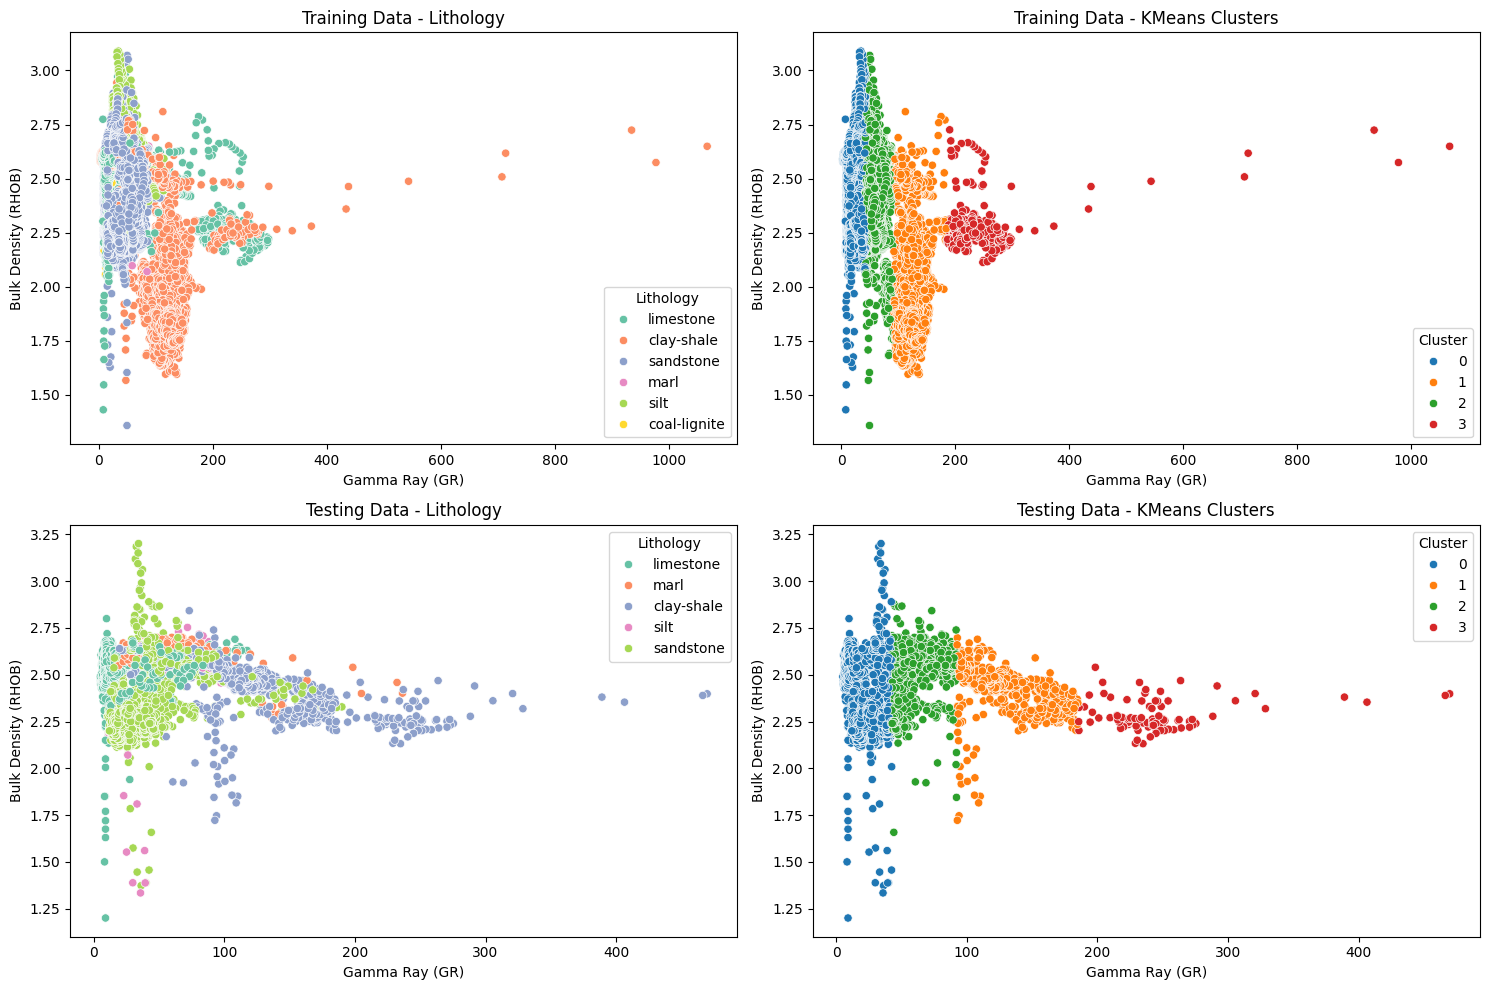

In [13]:
# Create a figure with 2 rows and 2 columns for training and testing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First subplot (top-left): scatter plot by lithology for training data
sns.scatterplot(ax=axes[0, 0], x=training_wells['GR'], y=training_wells['RHOB'], hue=training_wells['Lithology'], palette='Set2')
axes[0, 0].set_title('Training Data - Lithology')
axes[0, 0].set_xlabel('Gamma Ray (GR)')
axes[0, 0].set_ylabel('Bulk Density (RHOB)')
axes[0, 0].legend(title='Lithology')

# Second subplot (top-right): scatter plot by KMeans clustering for training data
sns.scatterplot(ax=axes[0, 1], x=training_wells['GR'], y=training_wells['RHOB'], hue=training_wells['Cluster'], palette='tab10')
axes[0, 1].set_title('Training Data - KMeans Clusters')
axes[0, 1].set_xlabel('Gamma Ray (GR)')
axes[0, 1].set_ylabel('Bulk Density (RHOB)')
axes[0, 1].legend(title='Cluster')

# Third subplot (bottom-left): scatter plot by lithology for testing data
sns.scatterplot(ax=axes[1, 0], x=testing_wells['GR'], y=testing_wells['RHOB'], hue=testing_wells['Lithology'], palette='Set2')
axes[1, 0].set_title('Testing Data - Lithology')
axes[1, 0].set_xlabel('Gamma Ray (GR)')
axes[1, 0].set_ylabel('Bulk Density (RHOB)')
axes[1, 0].legend(title='Lithology')

# Fourth subplot (bottom-right): scatter plot by KMeans clustering for testing data
sns.scatterplot(ax=axes[1, 1], x=testing_wells['GR'], y=testing_wells['RHOB'], hue=testing_wells['Cluster'], palette='tab10')
axes[1, 1].set_title('Testing Data - KMeans Clusters')
axes[1, 1].set_xlabel('Gamma Ray (GR)')
axes[1, 1].set_ylabel('Bulk Density (RHOB)')
axes[1, 1].legend(title='Cluster')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### Beyond the Tasks

The objective of the script below is to visualise well log data and lithology clusters for individual wells (the wells numbered 0 to 5). It plots various petrophysical properties along with lithology and clustering results, helping to interpret subsurface characteristics and lithological distribution in the well. The color-coded facies plots make it easier to distinguish between different rock types and clusters.

The *create_plot* function creates multi-track plots for well log data, with each track displaying different data curves (e.g., $GR$, $RHOB$, etc.) along a common depth axis.

In [14]:
def create_plot(wellname, dataframe, curves_to_plot, depth_curve, log_curves=[], facies_curves=[]):
    # count the number of tracks we need
    num_tracks = len(curves_to_plot)
    
    facies_color = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D', 'red','black', 'blue']
    
            
    # setup the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    
    # create a super title for the entire plot
    fig.suptitle(wellname, fontsize=20, y=1.05)
    
    # loop through each curve in curves_to_plot and create a track with that data
    for i, curve in enumerate(curves_to_plot):
        if curve in facies_curves:
            cmap_facies = colors.ListedColormap(facies_color[0:dataframe[curve].max()], 'indexed')
            
            cluster=np.repeat(np.expand_dims(dataframe[curve].values,1), 100, 1)
            im=ax[i].imshow(cluster, interpolation='none', cmap=cmap_facies, aspect='auto',vmin=dataframe[curve].min(),vmax=dataframe[curve].max(), 
                            extent=[0,20, depth_curve.max(), depth_curve.min()])
        else:
            ax[i].plot(dataframe[curve], depth_curve)

        
        # setup a few plot cosmetics
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].grid(which='major', color='lightgrey', linestyle='-')
        
        # data depth from shallow to deep
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())

        # only set the y-label for the first track. Hide it for the rest
        if i == 0:
            ax[i].set_ylabel('DEPTH (m)', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')

    plt.tight_layout()
    plt.show()
    
    return cmap_facies

lithology_numbers = {300: 'sandstone',
                 800: 'marl',
                 700: 'limestone',
                 400: 'silt',
                 600: 'clay-shale',
                 900: 'coal-lignite'
}

simple_lithology_numbers = {'sandstone': 1,
                 'marl': 2,
                 'limestone': 3,
                 'silt': 4,
                 'clay-shale': 5,
                 'coal-lignite': 6
}

#  Map lithology for training and testing wells
training_wells['LITH'] = training_wells['Lithology'].map(lithology_numbers)
training_wells['LITH_SI'] = training_wells['Lithology'].map(simple_lithology_numbers)

testing_wells['LITH'] = testing_wells['Lithology'].map(lithology_numbers)
testing_wells['LITH_SI'] = testing_wells['Lithology'].map(simple_lithology_numbers)

The script generates the plots for a selected well (well = 5), visualizing petrophysical logs and facies data using the predefined curve list.

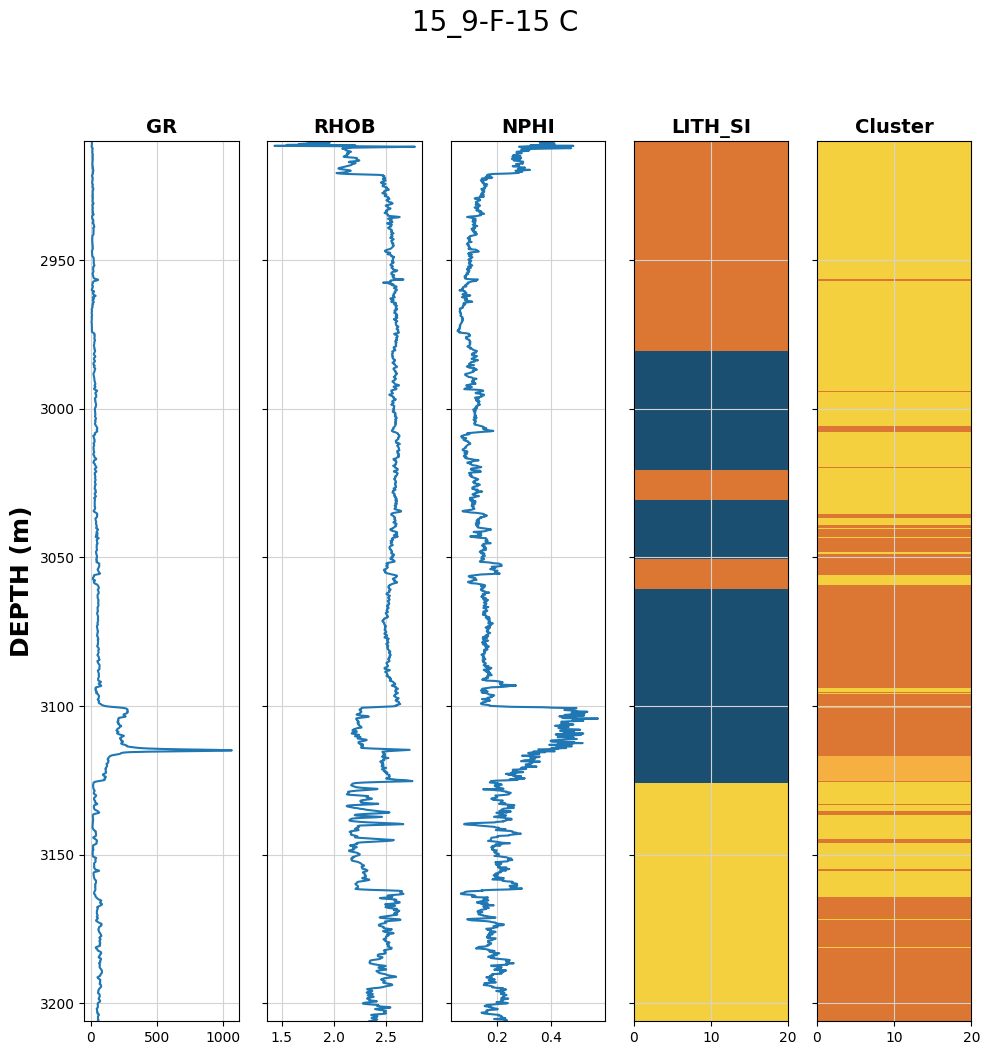

In [15]:
# set up the curves to plot
curves_to_plot = ['GR', 'RHOB', 'NPHI',  'LITH_SI', 'Cluster']
logarithmic_curves = ['RDEP']
facies_curve=['Cluster', 'LITH_SI']

# create plot by passing in the relevant well index number
well = 3
cmap_facies = create_plot(training_well_names[well], 
            training_wells[training_wells['Well Name'] == training_well_names[well]], 
            curves_to_plot, 
            training_wells[training_wells['Well Name'] == training_well_names[well]]['Depth'], 
            logarithmic_curves, facies_curve)

**Reference**

- Equinor, A. S. A. (2023). Volve field dataset.
- Andy McDonald. (2020). Petrophysics-Python-Series/18 - Unsupervised Clustering for Lithofacies.ipynb at master · andymcdgeo/Petrophysics-Python-Series. GitHub.